<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/Simpsons/Simpsons_Classification_20210514_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Classification

In [79]:
import os
import time
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from pprint import pprint
from datetime import datetime
from sklearn.model_selection import train_test_split



### for notebook users
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
###train 폴더 속 하위 폴더 -> target 확인

target = os.listdir("/content/drive/MyDrive/Colab Notebooks/simpsons/train")
target.sort()

print("Number of targets: ",len(target))

category = {}
for i, name in enumerate(target):
    category[i]= name

pprint(category)

Number of targets:  9
{0: 'bart',
 1: 'charles_montgomery',
 2: 'krusty',
 3: 'lisa_simpson',
 4: 'marge_simpson',
 5: 'milhouse_van_houten',
 6: 'moe_szyslak',
 7: 'ned_flanders',
 8: 'principal_skinner'}


## 저장된 npz 파일 불러오기
구글드라이브에서 불러오는 데에 상당히 오래 걸리기 때문에, 한 번 불러온 후 npz 파일로 저장해놓은 상황. <br>
만약에 저장하는 코드가 보고 싶으시다면 0508 파일 참고해주세요.

In [6]:
train_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/train_224_npz.npz")
test_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/test_224_npz.npz")

In [7]:
X_train = train_dataset["X_train_npz"]
y_train = train_dataset["y_train_npz"]

y_train = to_categorical(y_train, len(target))

X_test = test_dataset["X_test_npz"]
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv", index_col=0)
y_test = np.array(y_test_list["files"])

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))   # 아직 어떻게 할지 못 정함

X_train shape: (11248, 224, 224, 3)
y_train shape: (11248, 9)
X_test shape: (1086, 224, 224, 3)
y_test shape: (1086,)


## Data Processing & Data Inspection

In [9]:
train_batch_size = 64
test_batch_size = 64
image_size = 224


### 그냥 원본으로 불러서 원하는 해상도로 crop할지 고민 중
augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.5),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.Cutout(num_holes = 32, max_h_size=4,
                                      max_w_size=4, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])
augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

### Defining Dataloader

In [10]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        # batch_size 쓰면 마지막 batch에서 문제 발생
        # 대안으로 indices.shape[0] 사용
        image_batch = np.zeros((indices.shape[0], image_size, image_size, 3))

        for image_index in range(indices.shape[0]):

            ### 이 안에서 다룰지, 밖에서 해결할지 고민 중
            ### image = cv2.cvtColor(cv2.imdead(indices.shape[image_index]), cv2.COLOR_BGR2RGB)
            ### image = cv2.resize(image, (image_size, image_size))

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [11]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
train_loader = Dataloader(train_data, train_labels, batch_size=train_batch_size,
                          augmentor=augmentor_train, shuffle=True)
val_loader = Dataloader(val_data, val_labels, batch_size=train_batch_size,
                        augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size,
                         augmentor=augmentor_test, shuffle=False)

In [14]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Train Set)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64, 9)
Data  : (64, 224, 224, 3)


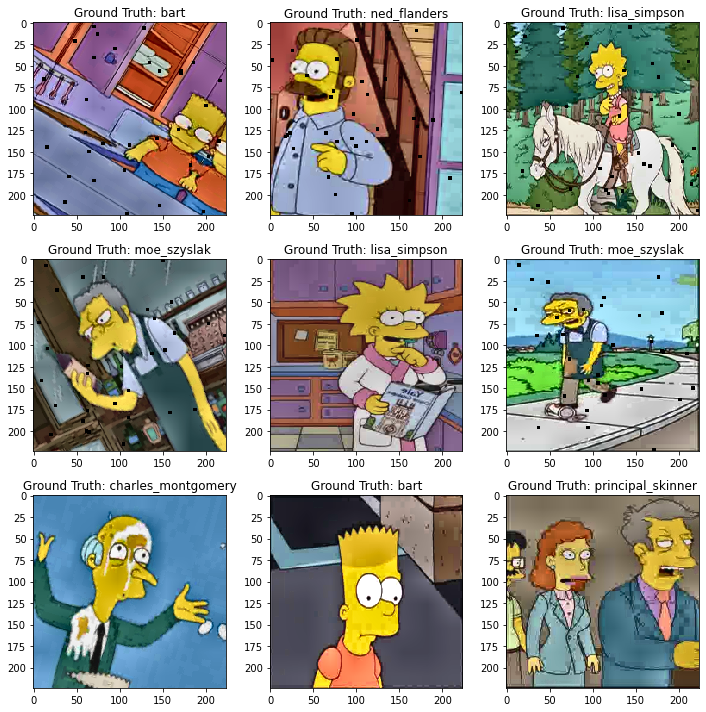

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [16]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Test Set)
### Scaling을 제외한 Augmentation이 적용되면 안 됨!!!
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64,)
Data  : (64, 224, 224, 3)


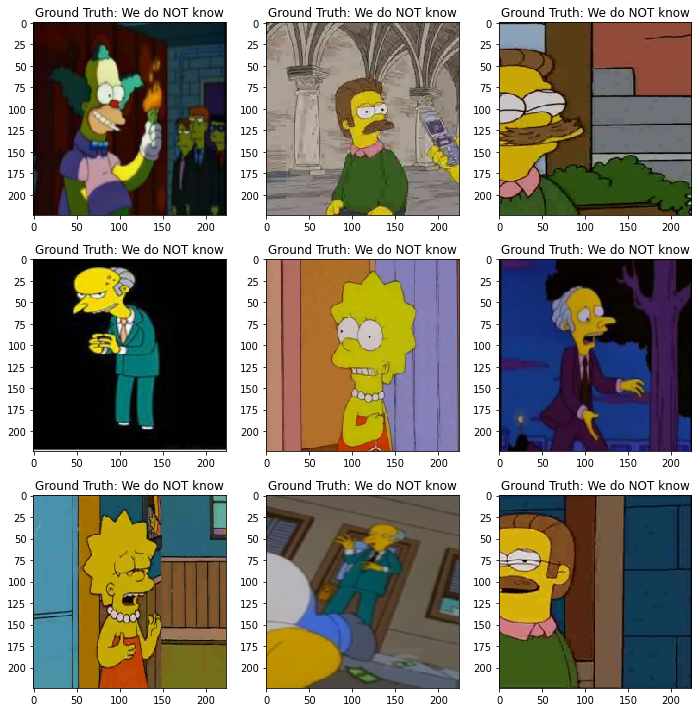

In [17]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()

## CNN Modeling 1 (VGG16)
MNIST의 경우, size가 28 x 28로 너무 작아서 pretrained model을 이용하기 어려웠음. <br>
하지만 이번 dataset은 size가 충분히 크기 때문에 여러 pretrained model을 사용해보기로 함.

In [51]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet50V2, Xception

input_tensor= Input(shape=(224, 224, 3))

base_model = VGG16(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)   # 원래 VGG 논문에서는 flatten을 썼는데, 그때는 GlobalAveragePooling이 없던 시절... 그러면 이게 맞지 않을까?
x = Dropout(rate=0.5)(x)
x = Dense(50, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [52]:
earlystop = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3,
                                          verbose=1, factor=0.5, min_lr=0.0001)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.9, alpha=0.0, name=None
)

In [63]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

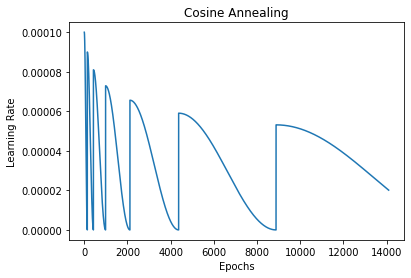

In [64]:
steps_list = range(100*141)
lr_list = [lr_Cosine_Decay(step) for step in steps_list]

plot_scheduler(epochs_list, lr_list, title="Cosine Annealing")

In [53]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
141/141 [==============================] - 74s 511ms/step - loss: 2.2589 - accuracy: 0.1087 - val_loss: 2.1937 - val_accuracy: 0.1489
Epoch 2/100
141/141 [==============================] - 73s 516ms/step - loss: 2.1974 - accuracy: 0.1290 - val_loss: 2.1953 - val_accuracy: 0.1396
Epoch 3/100
141/141 [==============================] - 71s 505ms/step - loss: 2.1959 - accuracy: 0.1160 - val_loss: 2.1948 - val_accuracy: 0.1289
Epoch 4/100
141/141 [==============================] - 71s 503ms/step - loss: 2.1948 - accuracy: 0.1248 - val_loss: 2.1937 - val_accuracy: 0.1147
Epoch 5/100
141/141 [==============================] - 72s 507ms/step - loss: 2.1928 - accuracy: 0.1242 - val_loss: 2.1929 - val_accuracy: 0.1453
Epoch 6/100
141/141 [==============================] - 71s 503ms/step - loss: 2.1930 - accuracy: 0.1207 - val_loss: 2.1923 - val_accuracy: 0.1276
Epoch 7/100
141/141 [==============================] - 72s 505ms/step - loss: 2.1912 - accuracy: 0.1247 - val_loss: 2.1905 -

## Experiment


In [55]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

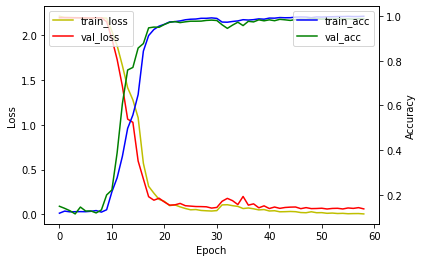

In [56]:
acc_loss_plot(hist)

## Answer Sheet 만들기

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()
    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(9 + tm.tm_hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [59]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210514_213824.csv


## CNN Modeling 2 (Xception)

In [88]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet50V2, Xception

input_tensor= Input(shape=(224, 224, 3))

base_model = Xception(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_23[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [89]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.8, alpha=0.0, name=None
)

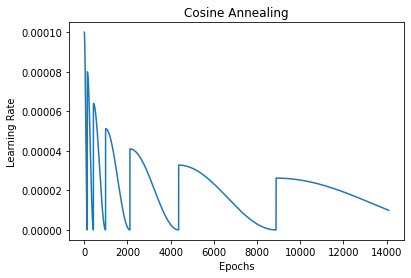

In [91]:
steps_list = range(100*141)
lr_list = [lr_Cosine_Decay(step) for step in steps_list]

plot_scheduler(epochs_list, lr_list, title="Cosine Annealing")

In [90]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
141/141 [==============================] - 125s 847ms/step - loss: 1.8785 - accuracy: 0.3280 - val_loss: 0.6261 - val_accuracy: 0.8253
Epoch 2/100
141/141 [==============================] - 118s 837ms/step - loss: 0.4237 - accuracy: 0.8916 - val_loss: 0.1463 - val_accuracy: 0.9551
Epoch 3/100
141/141 [==============================] - 118s 838ms/step - loss: 0.1432 - accuracy: 0.9601 - val_loss: 0.1323 - val_accuracy: 0.9618
Epoch 4/100
141/141 [==============================] - 119s 839ms/step - loss: 0.1208 - accuracy: 0.9673 - val_loss: 0.1053 - val_accuracy: 0.9658
Epoch 5/100
141/141 [==============================] - 118s 834ms/step - loss: 0.0881 - accuracy: 0.9735 - val_loss: 0.0867 - val_accuracy: 0.9742
Epoch 6/100
141/141 [==============================] - 119s 839ms/step - loss: 0.0758 - accuracy: 0.9800 - val_loss: 0.0920 - val_accuracy: 0.9729
Epoch 7/100
141/141 [==============================] - 118s 838ms/step - loss: 0.0560 - accuracy: 0.9846 - val_loss: 0

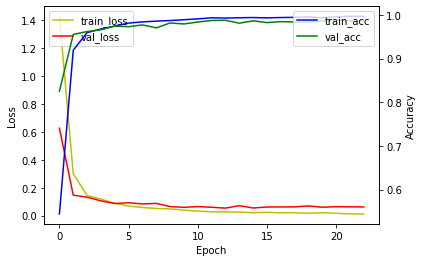

In [93]:
acc_loss_plot(hist)

In [94]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210514_245244.csv
